In [ ]:
#importando as bibliotecas necessárias ('sidrapy' é a biblioteca do Python para dados do SIDRA)

!pip install sidrapy
import sidrapy
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Estabelecendo função para sempre marcar data atual
data_atual = date.today()

data_str = str(data_atual)

# Importa as variações do IPCA
ipca_raw = sidrapy.get_table(table_code = '1737',
                             territorial_level = '1',
                             ibge_territorial_code = 'all',
                             variable = '63,69,2263,2264,2265',
                             period = 'last%20472')

In [ ]:
 #Realiza a limpeza e manipulação da tabela
ipca =  (
    ipca_raw
    .loc[1:,['V', 'D2C', 'D3N']]
    .rename(columns = {'V': 'value',
                       'D2C': 'date',
                       'D3N': 'variable'}
            )
    .assign(variable = lambda x: x['variable'].replace({'IPCA - Variação mensal' : 'Var. mensal (%)',
                                                        'IPCA - Variação acumulada no ano': 'Var. acumulada no ano (%)', 
                                                        'IPCA - Variação acumulada em 3 meses' : 'Var. MM3M (%)',
                                                        'IPCA - Variação acumulada em 6 meses': 'Var. MM6M (%)',
                                                        'IPCA - Variação acumulada em 12 meses' : 'Var. MM12M (%)'}),
            date  = lambda x: pd.to_datetime(x['date'],
                                              format = "%Y%m"),
            value = lambda x: x['value'].astype(float)
           )
    .pipe(lambda x: x.loc[x.date > '2007-01-01' ]
          )
        )

In [ ]:
# Configura o tema do gráfico
## Cores
colors = ['#282f6b', '#b22200', '#eace3f', '#224f20', '#b35c1e', '#419391', '#839c56','#3b89bc']

## Tamanho
theme = {'figure.figsize' : (15, 10)}

## Aplica o tema
sns.set_theme(rc = theme,
              palette = colors)

Text(1.0, -0.08, 'Fonte: Sidra/IBGE')

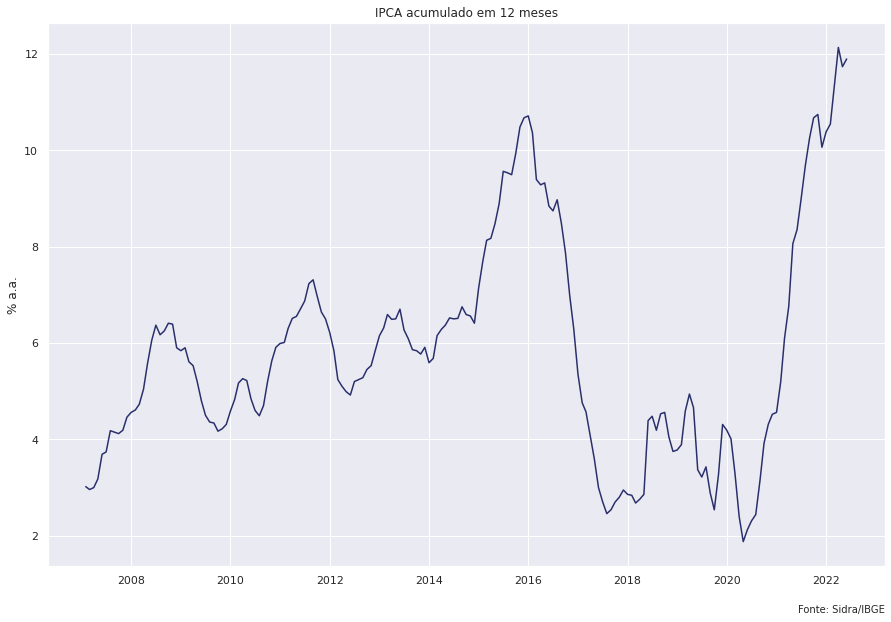

In [ ]:
# Filtra somente para o IPCA acumulado em 12 meses
ipca_12m = (   
            ipca
            .pipe(lambda x: x.loc[x.variable == 'Var. MM12M (%)'])
           )

# Plota o IPCA acumulado em 12 meses
sns.lineplot(x = 'date',
             y = 'value',
             data = ipca_12m).set(title = 'IPCA acumulado em 12 meses',
                                                           xlabel = '',
                                                           ylabel = '% a.a.')

# Adiciona a fonte no gráfico           
plt.annotate('Fonte: Sidra/IBGE',
            xy = (1.0, -0.08),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)

Text(1.0, -0.13, 'Fonte: Sidra/IBGE')

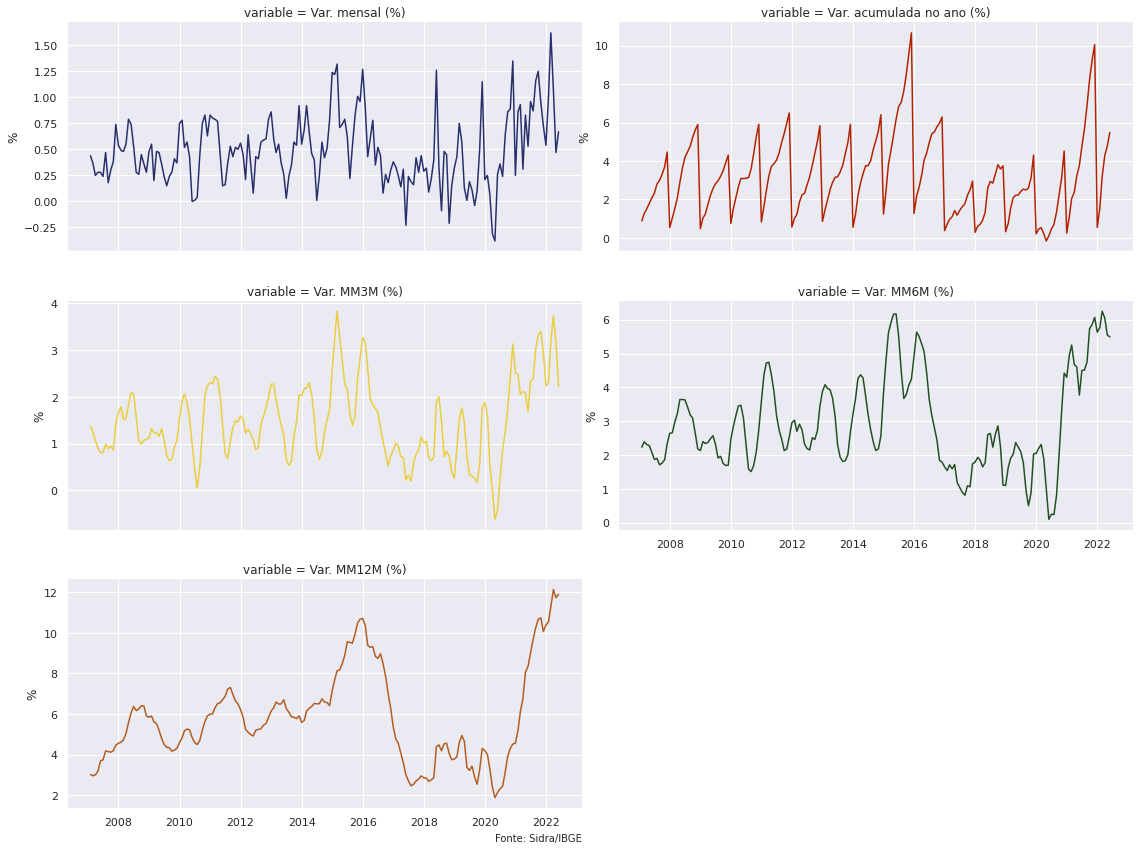

In [ ]:
# Plota todas as variações
g = sns.FacetGrid(ipca, col = 'variable',
                  col_wrap = 2,
                  hue = 'variable',
                  sharey = False,
                  height = 4,
                  aspect = 2)


g.map_dataframe(sns.lineplot, 
                x = 'date',
                y = 'value').set(xlabel = "",
                                 ylabel = '%')

# Adiciona a fonte no gráfico           
plt.annotate('Fonte: Sidra/IBGE',
            xy = (1.0, -0.13),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)

In [ ]:
# Importa as variações e os pesos dos grupos do IPCA
ipca_gp_raw = sidrapy.get_table(table_code = '7060',
                             territorial_level = '1',
                             ibge_territorial_code = 'all',
                             variable = '63,66',
                             period = 'all',
                             classification = '315/7170,7445,7486,7558,7625,7660,7712,7766,7786'
                             )

In [ ]:
# Realiza a limpeza e manipulação da tabela
ipca_gp =  (
    ipca_gp_raw
    .loc[1:,['V', 'D2C', 'D3N', 'D4N']]
    .rename(columns = {'V': 'value',
                       'D2C': 'date',
                       'D3N': 'variable',
                       'D4N': 'groups'})
    .assign(variable = lambda x: x['variable'].replace({'IPCA - Variação mensal' : 'variacao',
                                                        'IPCA - Peso mensal': 'peso'}),
            date  = lambda x: pd.to_datetime(x['date'],
                                              format = "%Y%m"),
            value = lambda x: x['value'].astype(float),
            groups = lambda x: x['groups'].astype(str)
           )
    .pipe(lambda x: x.loc[x.date > '2007-01-01'])
        )

In [ ]:
# Torna em formato wide (pivotar) e calcula a contribuição de cada grupo pro IPCA
ipca_gp_wider = (
    ipca_gp
    .pivot_table(index = ['date', 'groups'],
                 columns = 'variable',
                 values = 'value')
    .reset_index()
    .assign(contribuicao = lambda x: (x.peso * x.variacao) / 100)
                )

In [ ]:
# Importa a biblioteca plotly
!pip install plotly
import plotly.express as px

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Plota a contribuição de cada grupo com plotly
px.bar(ipca_gp_wider,
       x = 'date',
       y = 'contribuicao',
       color = 'groups',
       color_discrete_sequence = colors)

In [ ]:
print(ipca)

      value       date                   variable
1436   0.44 2007-02-01            Var. mensal (%)
1437   0.88 2007-02-01  Var. acumulada no ano (%)
1438   1.37 2007-02-01              Var. MM3M (%)
1439   2.23 2007-02-01              Var. MM6M (%)
1440   3.02 2007-02-01             Var. MM12M (%)
...     ...        ...                        ...
2356   0.67 2022-06-01            Var. mensal (%)
2357   5.49 2022-06-01  Var. acumulada no ano (%)
2358   2.22 2022-06-01              Var. MM3M (%)
2359   5.49 2022-06-01              Var. MM6M (%)
2360  11.89 2022-06-01             Var. MM12M (%)

[925 rows x 3 columns]


In [ ]:
print(ipca_gp)

       value       date  variable                       groups
1     0.3900 2020-01-01  variacao      1.Alimentação e bebidas
2     0.5500 2020-01-01  variacao                  2.Habitação
3    -0.0700 2020-01-01  variacao      3.Artigos de residência
4    -0.4800 2020-01-01  variacao                  4.Vestuário
5     0.3200 2020-01-01  variacao                5.Transportes
..       ...        ...       ...                          ...
536  22.3071 2022-06-01      peso                5.Transportes
537  12.3669 2022-06-01      peso  6.Saúde e cuidados pessoais
538   9.7192 2022-06-01      peso          7.Despesas pessoais
539   5.6342 2022-06-01      peso                   8.Educação
540   5.0820 2022-06-01      peso                9.Comunicação

[540 rows x 4 columns]


In [ ]:
ipca_gp_df = ipca_gp.loc[ipca_gp['date'] == '2022-06-01']
print(ipca_gp_df)

#salvando o DataFrame para arquivo do tipo excel
#também pode-se trocar o '.xlsx' por '.csv', e 'to_excel' para 'to_csv' 
file_name = 'IPCA_GP_' + data_str + '.xlsx'
ipca_gp_df.to_excel(file_name)


       value       date  variable                       groups
523   0.8000 2022-06-01  variacao      1.Alimentação e bebidas
524   0.4100 2022-06-01  variacao                  2.Habitação
525   0.5500 2022-06-01  variacao      3.Artigos de residência
526   1.6700 2022-06-01  variacao                  4.Vestuário
527   0.5700 2022-06-01  variacao                5.Transportes
528   1.2400 2022-06-01  variacao  6.Saúde e cuidados pessoais
529   0.4900 2022-06-01  variacao          7.Despesas pessoais
530   0.0900 2022-06-01  variacao                   8.Educação
531   0.1600 2022-06-01  variacao                9.Comunicação
532  21.2610 2022-06-01      peso      1.Alimentação e bebidas
533  15.2484 2022-06-01      peso                  2.Habitação
534   3.9376 2022-06-01      peso      3.Artigos de residência
535   4.4436 2022-06-01      peso                  4.Vestuário
536  22.3071 2022-06-01      peso                5.Transportes
537  12.3669 2022-06-01      peso  6.Saúde e cuidados p

In [ ]:
ipca_df = ipca.loc[ipca['date'] == '2022-06-01']
print(ipca_df)

#salvando o DataFrame para arquivo do tipo excel
file_name = 'IPCA_' + data_str + '.xlsx'
ipca_df.to_excel(file_name)

      value       date                   variable
2356   0.67 2022-06-01            Var. mensal (%)
2357   5.49 2022-06-01  Var. acumulada no ano (%)
2358   2.22 2022-06-01              Var. MM3M (%)
2359   5.49 2022-06-01              Var. MM6M (%)
2360  11.89 2022-06-01             Var. MM12M (%)


In [ ]:
#Pivotando o DataFrame com apenas o mês atual

ipca_gp_wider = (
    ipca_gp_df
    .pivot_table(index = ['date', 'groups'],
                 columns = 'variable',
                 values = 'value')
    .reset_index()
    .assign(contribuicao = lambda x: (x.peso * x.variacao) / 100)
                )

In [ ]:
# Plota a contribuição de cada grupo com plotly
px.bar(ipca_gp_wider,
       x = 'date',
       y = 'contribuicao',
       color = 'groups',
       barmode = 'group',
       color_discrete_sequence = colors)